In [5]:
# CASE DE VENDAS ATUALIZADO COM MAIS MODELOS E BACKTEST

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA, Naive, SeasonalNaive

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [6]:
# 1. Carregar dados
df = pd.read_csv(r"C:\Users\Edmundo Simeon\Downloads\resumo_vendas_regiao 1.csv")

df = df.rename(columns={
 
    "data": "ds",
    "vendas": "y"
})


df['ds'] = pd.to_datetime(df['ds'])

# Agrupar por mês
df_grouped = df.groupby(df['ds'].dt.to_period('M'))['y'].sum().reset_index()
df_grouped['ds'] = df_grouped['ds'].dt.to_timestamp()

# Ajustar colunas para StatsForecast
df_grouped['unique_id'] = 'serie1'
df_grouped = df_grouped[['unique_id', 'ds', 'y']]

print(df_grouped.head())


  unique_id         ds            y
0    serie1 2021-01-01   3632707.42
1    serie1 2021-02-01  12812183.31
2    serie1 2021-03-01  21306031.44
3    serie1 2021-04-01   2329599.24
4    serie1 2021-05-01   9424709.03


In [7]:
# 2. Definir modelos
sf = StatsForecast(
    models=[
        AutoETS(season_length=12),
        AutoARIMA(season_length=12),
        Naive(),
        SeasonalNaive(season_length=12)
    ],
    freq='ME',
    n_jobs=-1
)


In [8]:
# 3. Cross-validation (backtest)
cv_results = sf.cross_validation(
    df=df_grouped,
    h=12,
    step_size=12,
    n_windows=3
)

print(cv_results.head())


                  ds     cutoff           y     AutoETS   AutoARIMA  \
unique_id                                                             
serie1    2022-09-01 2022-08-01   6855019.5  10410530.0  10113390.0   
serie1    2022-10-01 2022-08-01  15056373.0  10410530.0  10113388.0   
serie1    2022-11-01 2022-08-01   9206098.0  10410530.0  10113386.0   
serie1    2022-12-01 2022-08-01  12771209.0  10410530.0  10113384.0   
serie1    2023-01-01 2022-08-01  19653944.0  10410530.0  10113382.0   

                Naive  SeasonalNaive  
unique_id                             
serie1     11548621.0      6269797.0  
serie1     11548621.0      5120251.5  
serie1     11548621.0     19376806.0  
serie1     11548621.0     10202009.0  
serie1     11548621.0      5096952.5  


C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [9]:
# 4. Calcular métricas para cada modelo
def calc_metrics(df, model):
    df_eval = df.dropna(subset=['y', model])
    y_true = df_eval['y'].values
    y_pred = df_eval[model].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

metrics = {}
for model in ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive']:
    metrics[model] = calc_metrics(cv_results, model)

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                    RMSE        MAE       MAPE        R2
AutoETS        7913275.0  4843473.5  49.928596 -0.029795
AutoARIMA      8433191.0  5064096.0  48.082291 -0.169559
Naive          8574642.0  5409841.5  55.788254 -0.209122
SeasonalNaive  9415882.0  5947142.5  57.639511 -0.458009


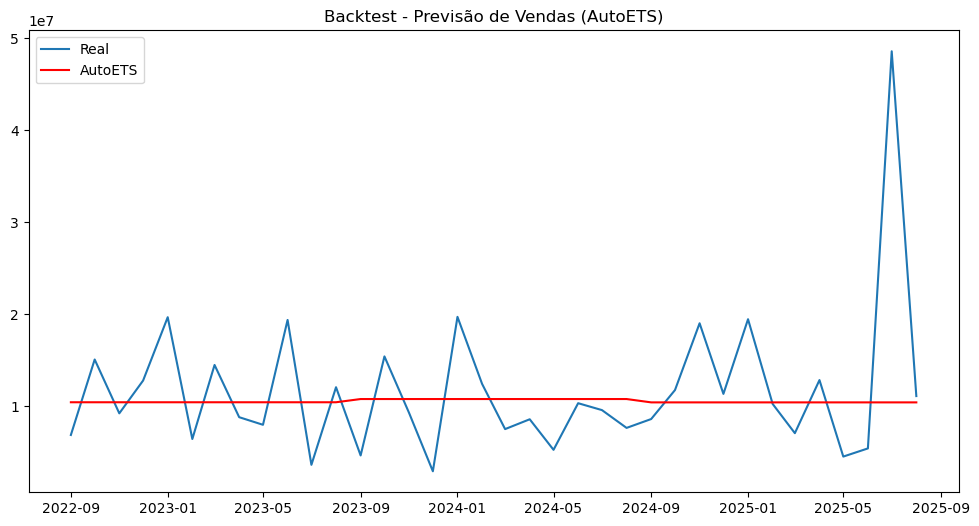

In [10]:
# 5. Plotar resultados do backtest (um exemplo com AutoETS)
df_eval = cv_results.dropna(subset=['y', 'AutoETS'])

plt.figure(figsize=(12,6))
plt.plot(df_eval['ds'], df_eval['y'], label='Real')
plt.plot(df_eval['ds'], df_eval['AutoETS'], label='AutoETS', color='red')
plt.legend()
plt.title("Backtest - Previsão de Vendas (AutoETS)")
plt.show()


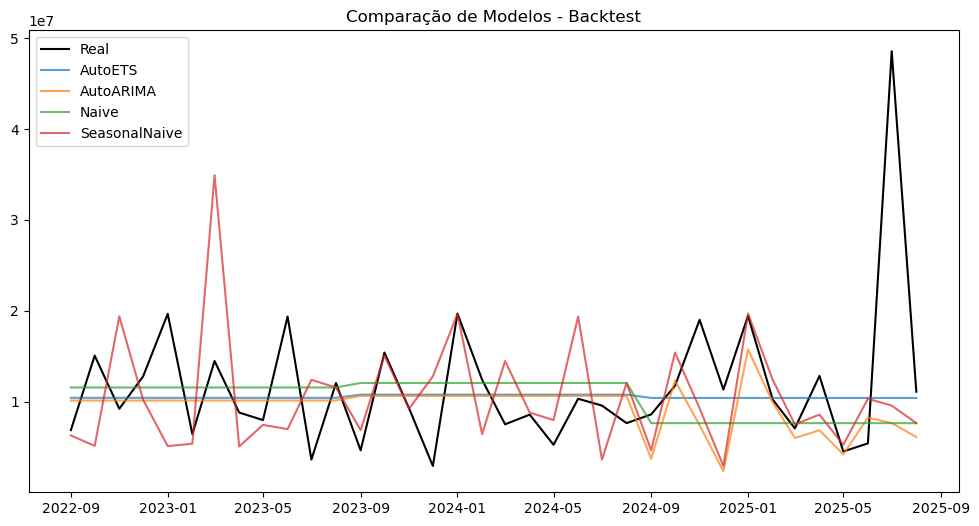

In [11]:
# 6. Plot comparativo de modelos (opcional)
plt.figure(figsize=(12,6))
plt.plot(cv_results['ds'], cv_results['y'], label='Real', color='black')

for model in ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive']:
    plt.plot(cv_results['ds'], cv_results[model], label=model, alpha=0.7)

plt.legend()
plt.title("Comparação de Modelos - Backtest")
plt.show()


In [12]:
from statsforecast.models import Theta, DynamicOptimizedTheta


In [13]:
sf = StatsForecast(
    models=[
        AutoETS(season_length=12),
        AutoARIMA(season_length=12),
        Naive(),
        SeasonalNaive(season_length=12),
        Theta(),
        DynamicOptimizedTheta(season_length=12)
    ],
    freq='ME',
    n_jobs=-1
)


In [14]:
cv_results = sf.cross_validation(
    df=df_grouped,
    h=12,
    step_size=12,
    n_windows=3
)

print(cv_results.head())


                  ds     cutoff           y     AutoETS   AutoARIMA  \
unique_id                                                             
serie1    2022-09-01 2022-08-01   6855019.5  10410530.0  10113390.0   
serie1    2022-10-01 2022-08-01  15056373.0  10410530.0  10113388.0   
serie1    2022-11-01 2022-08-01   9206098.0  10410530.0  10113386.0   
serie1    2022-12-01 2022-08-01  12771209.0  10410530.0  10113384.0   
serie1    2023-01-01 2022-08-01  19653944.0  10410530.0  10113382.0   

                Naive  SeasonalNaive       Theta  DynamicOptimizedTheta  
unique_id                                                                
serie1     11548621.0      6269797.0  10769634.0              9672385.0  
serie1     11548621.0      5120251.5  10830575.0              9672385.0  
serie1     11548621.0     19376806.0  10891515.0              9672385.0  
serie1     11548621.0     10202009.0  10952456.0              9672385.0  
serie1     11548621.0      5096952.5  11013396.0          

C:\Users\Edmundo Simeon\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [15]:
def calc_metrics(df, model):
    df_eval = df.dropna(subset=['y', model])
    y_true = df_eval['y'].values
    y_pred = df_eval[model].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape, "R2": r2}

models_to_eval = ['AutoETS', 'AutoARIMA', 'Naive', 'SeasonalNaive', 'Theta', 'DynamicOptimizedTheta']
metrics = {m: calc_metrics(cv_results, m) for m in models_to_eval}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                            RMSE        MAE       MAPE        R2
AutoETS                7913275.0  4843473.5  49.928596 -0.029795
AutoARIMA              8433191.0  5064096.0  48.082291 -0.169559
Naive                  8574642.0  5409841.5  55.788254 -0.209122
SeasonalNaive          9415882.0  5947142.5  57.639511 -0.458009
Theta                  8089175.5  5044384.5  53.058903 -0.076085
DynamicOptimizedTheta  8081776.0  4918096.0  48.570850 -0.074117


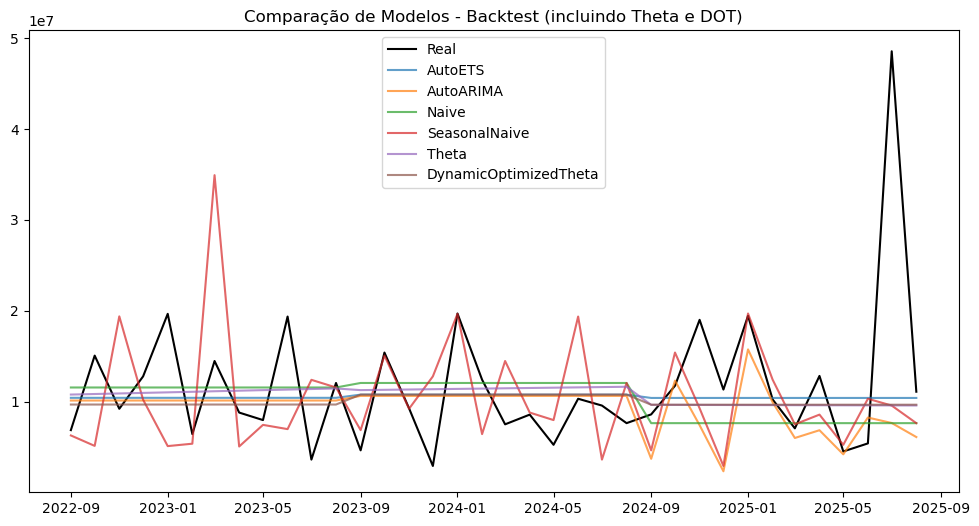

In [16]:
plt.figure(figsize=(12,6))
plt.plot(cv_results['ds'], cv_results['y'], label='Real', color='black')

for model in models_to_eval:
    plt.plot(cv_results['ds'], cv_results[model], label=model, alpha=0.7)

plt.legend()
plt.title("Comparação de Modelos - Backtest (incluindo Theta e DOT)")
plt.show()
